In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', '{:.10f}'.format)

In [2]:
import pickle

In [3]:
import plotnine as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

## Data Dictionary

| Field Name             | Description                                                         |
|------------------------|---------------------------------------------------------------------|
| VendorID               | A code indicating the TPEP provider that provided the record.<br>1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.                                                                                      |
| tpep_pickup_datetime   | The date and time when the meter was engaged.                                                                                                                                                               |
| tpep_dropoff_datetime  | The date and time when the meter was disengaged.                                                                                                                                                            |
| Passenger_count        | The number of passengers in the vehicle.<br>This is a driver-entered value.                                                                                                                                  |
| Trip_distance          | The elapsed trip distance in miles reported by the taximeter.                                                                                                                                               |
| PULocationID           | TLC Taxi Zone in which the taximeter was engaged.                                                                                                                                                           |
| DOLocationID           | TLC Taxi Zone in which the taximeter was disengaged.                                                                                                                                                        |
| RateCodeID             | The final rate code in effect at the end of the trip.<br>1= Standard rate<br>2= JFK<br>3= Newark<br>4= Nassau or Westchester<br>5= Negotiated fare<br>6= Group ride                                          |
| Store_and_fwd_flag     | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br>aka “store and forward,” because the vehicle did not have a connection to the server.<br>Y= store and forward trip<br>N= not a store and forward trip |
| Payment_type           | A numeric code signifying how the passenger paid for the trip.<br>1= Credit card<br>2= Cash<br>3= No charge<br>4= Dispute<br>5= Unknown<br>6= Voided trip                                                    |
| Fare_amount            | The time-and-distance fare calculated by the meter.                                                                                                                                                         |
| Extra                  | Miscellaneous extras and surcharges. Currently, this only includes the \\$0.50 and \\$1 rush hour and overnight charges.                                                                                         |
| MTA_tax                | \\$0.50 MTA tax that is automatically triggered based on the metered rate in use.                                                                                                                              |
| Improvement_surcharge  | \\$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.                                                                                          |
| Tip_amount             | Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.                                                                                                        |
| Tolls_amount           | Total amount of all tolls paid in trip.                                                                                                                                                                     |
| Total_amount           | The total amount charged to passengers. Does not include cash tips.                                                                                                                                         |
| Congestion_Surcharge   | Total amount collected in trip for NYS congestion surcharge.                                                                                                                                                |
| Airport_fee            | \\$1.25 for pick up only at LaGuardia and John F. Kennedy Airports. |

Source: [NYC TLC Trip Record Data](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

In [5]:
jan_data = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
feb_data = pd.read_parquet('./data/yellow_tripdata_2023-02.parquet')

In [6]:
# January data's 'Airport_fee' column is written as 'airport_fee'
jan_data.rename(columns={'airport_fee': 'Airport_fee'}, inplace=True)

In [7]:
print(f'Q1 Answer: there are {len(jan_data.columns)} columns in the dataset')

Q1 Answer: there are 19 columns in the dataset


In [8]:
jan_data['dataset'] = "January"
feb_data['dataset'] = "February"

data = pd.concat([jan_data, feb_data], axis=0, ignore_index=True)

In [9]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,dataset
0,2.0000000000,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0000000000,0.9700000000,1.0000000000,N,161.0000000000,141.0000000000,2.0000000000,9.3000000000,1.0000000000,0.5000000000,0.0000000000,0.0000000000,1.0000000000,14.3000000000,2.5000000000,0.0000000000,January
1,2.0000000000,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0000000000,1.1000000000,1.0000000000,N,43.0000000000,237.0000000000,1.0000000000,7.9000000000,1.0000000000,0.5000000000,4.0000000000,0.0000000000,1.0000000000,16.9000000000,2.5000000000,0.0000000000,January
2,2.0000000000,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0000000000,2.5100000000,1.0000000000,N,48.0000000000,238.0000000000,1.0000000000,14.9000000000,1.0000000000,0.5000000000,15.0000000000,0.0000000000,1.0000000000,34.9000000000,2.5000000000,0.0000000000,January
3,1.0000000000,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0000000000,1.9000000000,1.0000000000,N,138.0000000000,7.0000000000,1.0000000000,12.1000000000,7.2500000000,0.5000000000,0.0000000000,0.0000000000,1.0000000000,20.8500000000,0.0000000000,1.2500000000,January
4,2.0000000000,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0000000000,1.4300000000,1.0000000000,N,107.0000000000,79.0000000000,1.0000000000,11.4000000000,1.0000000000,0.5000000000,3.2800000000,0.0000000000,1.0000000000,19.6800000000,2.5000000000,0.0000000000,January


In [10]:
data['duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds()

In [11]:
data['duration'] = data['duration'] / 60

In [12]:
data['month'] = data['tpep_pickup_datetime'].dt.month_name()

In [13]:
data['year'] = data['tpep_pickup_datetime'].dt.year

In [14]:
data.duration.describe(percentiles = [0.95, 0.98, 0.99])

count   5980721.0000000000
mean         15.8380204577
std          42.7155893007
min         -43.6166666667
50%          11.6500000000
95%          36.8333333333
98%          49.3000000000
99%          58.0333333333
max       10029.1833333333
Name: duration, dtype: float64

In [15]:
upper_bound = data.duration.quantile(0.99)

/home/ubuntu/mlops-zoomcamp/.venv/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 279 rows containing non-finite values.
/home/ubuntu/mlops-zoomcamp/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 8 rows containing missing values.


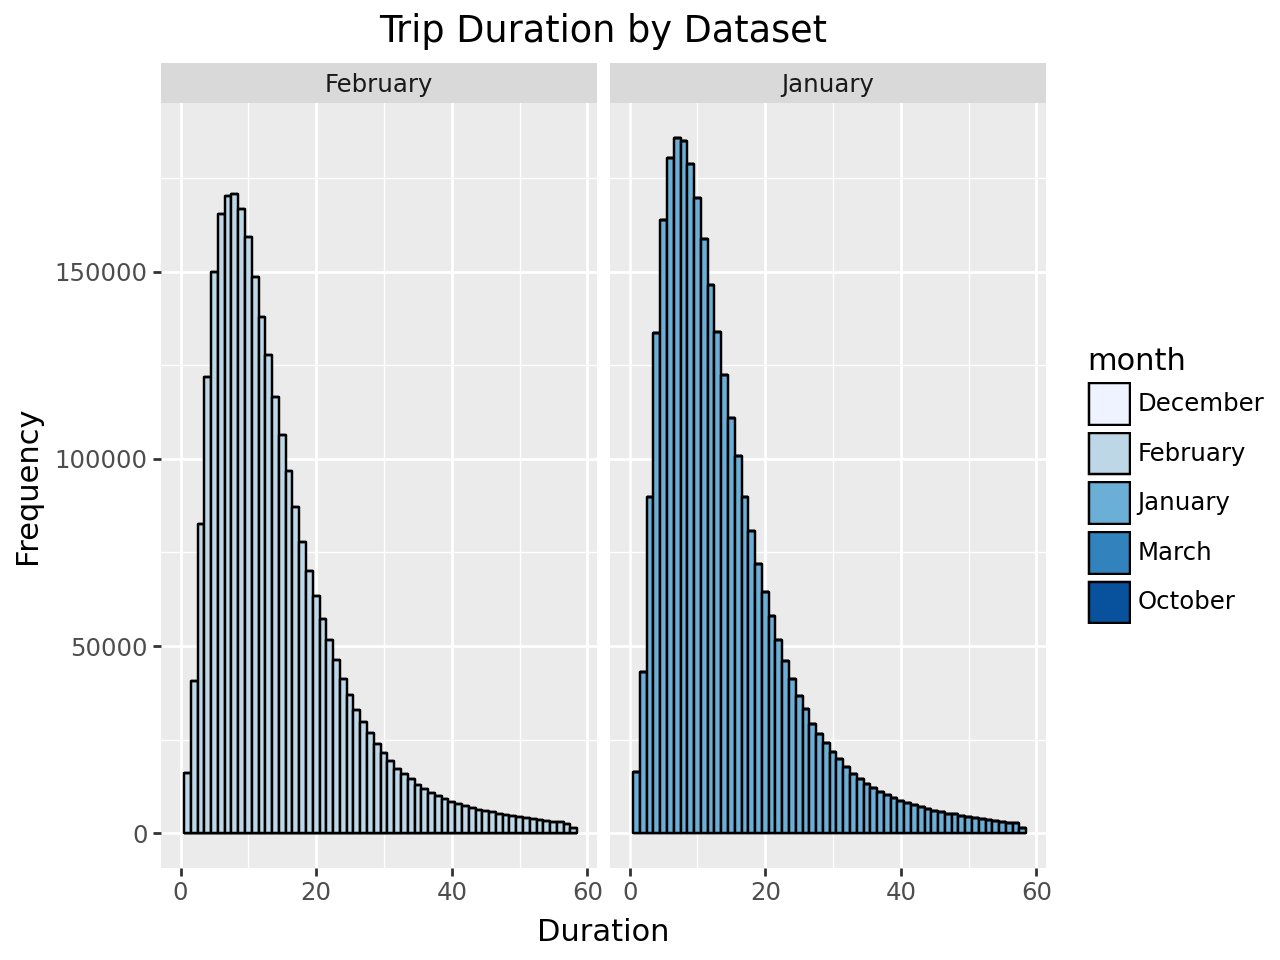

In [23]:
filtered_data = data[data['duration'] <= upper_bound]

(
    plt.ggplot(filtered_data, plt.aes(x = "duration", fill = "month")) + 
    plt.geom_histogram(binwidth = 1,
                       color = "black") +
    plt.labs(title = "Trip Duration by Dataset",
       x = "Duration",
       y = "Frequency") +
    plt.xlim(0, None) +
    plt.scale_fill_brewer(type='seq', palette='Blues') +
    plt.facet_wrap('~dataset')
)

It seems there are some records that do not correspond to the dataset's timeframe. Let's see how many of them are:

In [25]:
print(f'{len(data[~data['month'].isin(['January', 'February'])])} records do not match the dataset months')

84 records do not match the dataset months


In [28]:
print(f'{len(data[data['year'] != 2023])} records do not match the dataset year')

43 records do not match the dataset year


In [34]:
np.std(data[data['dataset'] == 'January']['duration'])

42.59434429744777

In [35]:
jan_durations = data[data['dataset'] == 'January']['duration']
jan_durations_filter = (jan_durations >= 1) & (jan_durations <= 60)

In [36]:
np.mean(jan_durations_filter)

0.9812202822125979

In [37]:
train_df = data[data['dataset'] == 'January'][jan_durations_filter]

In [38]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [39]:
train_df[categorical]= train_df[categorical].astype(str)


In [40]:
train_dicts = train_df[categorical + numerical].to_dict(orient='records')

In [41]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [42]:
X_train.shape

(3009173, 516)

In [43]:
X_train.shape

(3009173, 516)

In [44]:
target = 'duration'
y_train = train_df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.656752078217351

In [45]:
def create_prediction_real_df(real_values, predictions):
    df_real = pd.DataFrame({'value': real_values, 'label': 'real'})
    df_predictions = pd.DataFrame({'value': predictions, 'label': 'prediction'})
    df = pd.concat([df_real, df_predictions], ignore_index=True)
    return df

preds = create_prediction_real_df(y_train, y_pred)

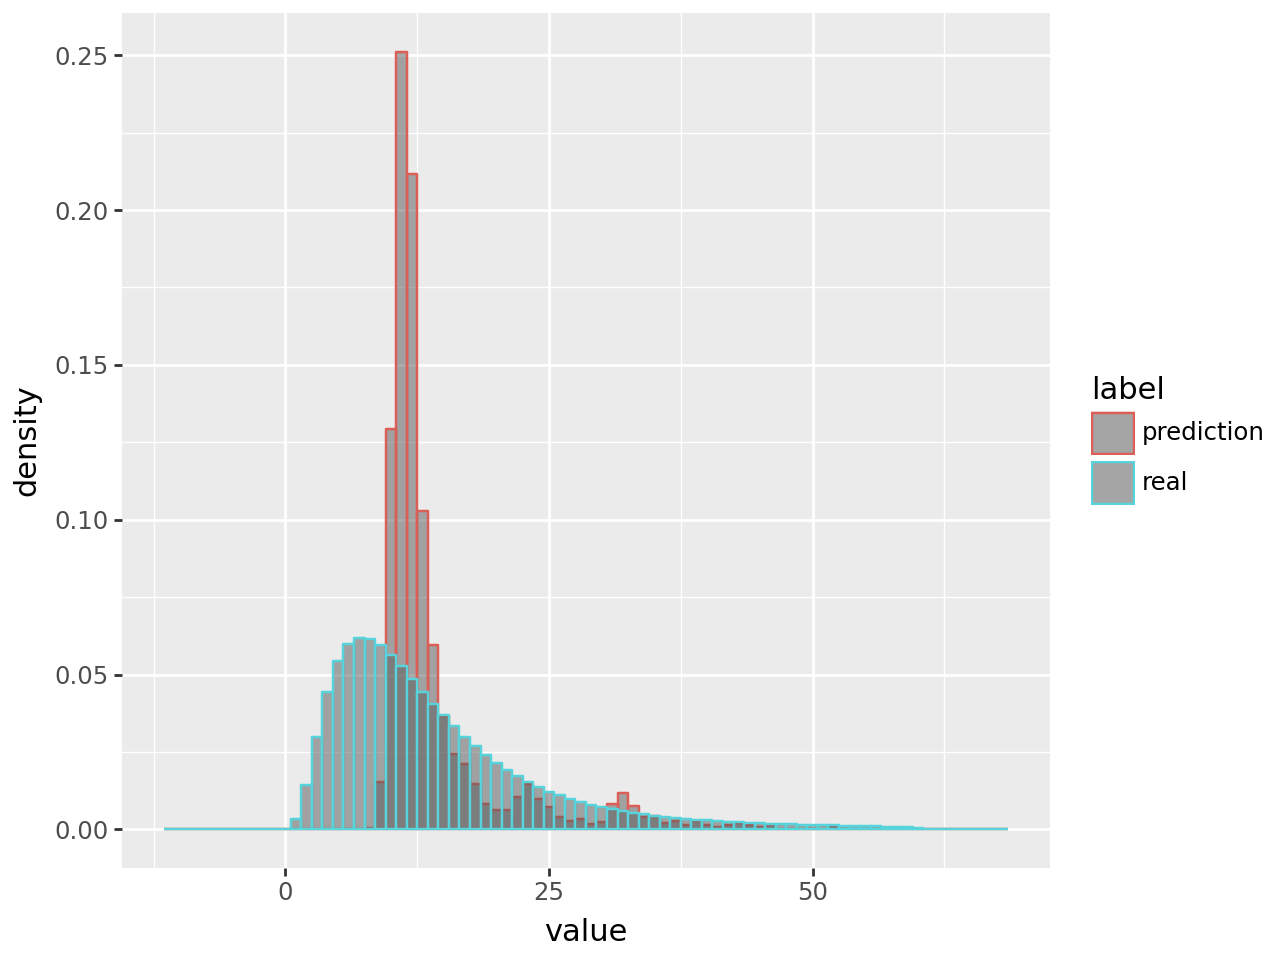

In [46]:
(
    plt.ggplot(preds, plt.aes(x='value', color='label')) +
    plt.geom_histogram(plt.aes(y='..density..'), alpha=0.5, binwidth = 1, position='identity')
)

In [47]:
def feats(data, month, categorical=['PULocationID', 'DOLocationID'],
          numerical=['trip_distance'], dv=None, target='duration'):
    df = data[data['dataset'] == month]
    durations_filter = (df['duration'] > 1) & (df['duration'] <= 60)
    print(f'Filtering out {sum(~durations_filter)} trips whose duration is not within (1, 60] minutes.')
    filtered_df = df[durations_filter].copy()
    # 
    filtered_df[categorical] = filtered_df[categorical].astype(str)
    dicts = filtered_df[categorical + numerical].to_dict(orient='records')
    
    y = filtered_df[target].values
    
    if dv:
        X = dv.transform(dicts)
        return X, y
    else:
        dv = DictVectorizer()
        X = dv.fit_transform(dicts)
        return X, y, dv

In [48]:
X_val, y_val = feats(data, 'February', dv=dv)

Filtering out 58325 trips whose duration is not within (1, 60] minutes.


In [49]:
y_val_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_val_pred)

7.817100705560177

In [ ]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)